In [1]:
from __future__ import print_function
from os.path import join
import time

import numpy as np
import pandas as pd
import pyxis as px
from astropy.io import fits
import matplotlib.pyplot as plt

#### Find range of noise to normalize over

In [12]:
n = 4000
data_dir = '/xdisk/timeifler/wxs0703/kl_nn/test_data/'
mins = np.empty((100000,), dtype=np.float64)
maxs = np.empty((100000,), dtype=np.float64)
for index in range(25):
    folder = index+1
    start_id = index*n
    for i in range(n):
        ID = start_id + i
        with fits.open(join(data_dir, f'temp_{folder}/testing_{ID}.fits')) as hdu:
            data = np.concatenate((hdu[1].data + hdu[2].data, hdu[3].data + hdu[4].data, hdu[5].data + hdu[6].data))
            mins[ID] = np.min(data)
            maxs[ID] = np.max(data)
    print(f'Folder {folder} complete')

Folder 1 complete
Folder 2 complete
Folder 3 complete
Folder 4 complete
Folder 5 complete
Folder 6 complete
Folder 7 complete
Folder 8 complete
Folder 9 complete
Folder 10 complete
Folder 11 complete
Folder 12 complete
Folder 13 complete
Folder 14 complete
Folder 15 complete
Folder 16 complete
Folder 17 complete
Folder 18 complete
Folder 19 complete
Folder 20 complete
Folder 21 complete
Folder 22 complete
Folder 23 complete
Folder 24 complete
Folder 25 complete


In [15]:
total = np.concatenate((maxs, mins))
print(np.min(total))
print(np.max(total))

-179.40306021006285
184.83903049721658


### Start here to create database

In [2]:
def normalize(samples):
    for par, values in samples.items():
        if par in par_ranges.keys():
            low, high = par_ranges[par]
            values -= low
            values /= high-low

In [3]:
def scale_noise(data, noise, SNR):
    data_copy = data.copy()
    noise_copy = noise.copy()
    segmask = data_copy > 0.1*np.max(data_copy)
    data_copy[~segmask] = 0
    noise_copy[~segmask] = 0
    target = np.sum(data_copy)/SNR
    noise *= target/np.sqrt(np.sum(noise_copy**2))
    return noise

In [4]:
par_ranges = \
{
    'g1': [-0.1, 0.1],
    'g2': [-0.1, 0.1],
    'theta_int': [-np.pi, np.pi],
    'sini': [0, 1],
    'v0': [-30, 30],
    'vcirc': [60, 540],
    'rscale': [0.1, 10],
    'hlr': [0.1, 5],
}

img_noise_range = [-100, 150]
spec_noise_range = [-260, 260]

In [5]:
data_dir = '/xdisk/timeifler/wxs0703/kl_nn/train_data_massive/'
with fits.open(join(data_dir, f'temp_{1}/training_{0}.fits')) as hdu:

    img = hdu[7].data
    noise = scale_noise(img, hdu[8].data, 15)
    img += noise
    low, high = img_noise_range
    img -= low
    img /= high-low

    specs = np.full((3, 64), 0.)
    for j in range(3):
        spec = hdu[2*j+1].data
        noise = scale_noise(spec, hdu[2*j+2].data, 15)
        spec += noise
        specs[j, :spec.shape[0]] = spec
    low, high = spec_noise_range
    specs -= low
    specs /= high-low

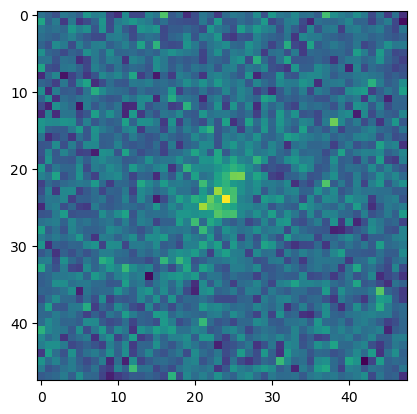

In [6]:
plt.imshow(img)

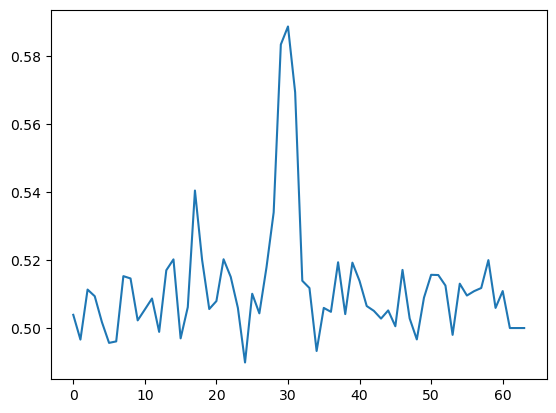

In [25]:
plt.plot(specs[0])

### Create training database

In [5]:
n = 4000
SNR = 15
data_dir = '/xdisk/timeifler/wxs0703/kl_nn/train_data_massive/'
samp_dir = '/xdisk/timeifler/wxs0703/kl_nn/samples/samples_massive.csv'
save_dir = '/xdisk/timeifler/wxs0703/kl_nn/train_data_massive/train_database_noise'
samples = pd.read_csv(samp_dir)
normalize(samples)

minmax = np.full((250, 4), 0.)

with px.Writer(dirpath=save_dir, map_size_limit=200000, ram_gb_limit=8) as db:
    
    for index in range(250):
        start = time.time()
        folder = index+1
        img_stack = np.full((n, 1, 48, 48), 0.)
        spec_stack = np.full((n, 1, 3, 64), 0.)
        fids = np.full((n, 8), 0.)
        start_id = index*n
        ids = np.arange(start_id, start_id+n, dtype=np.uint64)

        for i in range(n):
            
            ID = start_id + i

            with fits.open(join(data_dir, f'temp_{folder}/training_{ID}.fits')) as hdu:

                img = hdu[7].data
                noise = scale_noise(img, hdu[8].data, SNR)
                img += noise
                low, high = img_noise_range
                img -= low
                img /= high-low
                img_stack[i, 0] = img

                specs = np.full((3, 64), 0.)
                for j in range(3):
                    spec = hdu[2*j+1].data
                    noise = scale_noise(spec, hdu[2*j+2].data, SNR)
                    spec += noise
                    specs[j, :spec.shape[0]] = spec
                low, high = spec_noise_range
                specs -= low
                specs /= high-low
                spec_stack[i, 0] = specs

                fids[i] = np.array(samples.iloc[ID])[1:]
        
        minmax[index] = [np.max(img_stack), np.min(img_stack), np.max(spec_stack), np.min(spec_stack)]
        print(minmax[index])
                
        db.put_samples({'img': img_stack,
                        'spec': spec_stack,
                        'fid_pars': fids,
                        'id': ids})
        t = round(time.time() - start, 2)
        
        print(f'folder {folder} complete, {t} seconds')

np.save('minmax_train', minmax)

[0.86781937 0.1165622  0.74036663 0.27391095]
folder 1 complete, 57.76 seconds
[0.84136295 0.14359953 0.79001159 0.2897424 ]
folder 2 complete, 55.31 seconds
[0.82792383 0.14246759 0.76432839 0.21624111]
folder 3 complete, 47.44 seconds
[0.85528237 0.1387305  0.81337024 0.18023226]
folder 4 complete, 52.36 seconds
[0.80368251 0.1439859  0.69551251 0.25968152]
folder 5 complete, 52.32 seconds
[0.79773104 0.12537546 0.71436851 0.28321448]
folder 6 complete, 53.13 seconds
[0.86734986 0.12866788 0.72379279 0.27183958]
folder 7 complete, 54.71 seconds
[0.81256336 0.0698132  0.72812356 0.2574123 ]
folder 8 complete, 54.64 seconds
[0.81609696 0.13838354 0.84045964 0.24558766]
folder 9 complete, 56.82 seconds
[0.84189808 0.14561358 0.76235193 0.19865458]
folder 10 complete, 58.91 seconds
[0.85167074 0.15409446 0.72409529 0.16102458]
folder 11 complete, 56.43 seconds
[0.81459826 0.1018508  0.83220496 0.29832195]
folder 12 complete, 56.77 seconds
[0.8064732  0.15376841 0.78639887 0.2604013 ]
fol

folder 103 complete, 55.73 seconds
[0.85557961 0.10080829 0.7568099  0.30439983]
folder 104 complete, 55.52 seconds
[0.81613296 0.14251101 0.77688404 0.27401735]
folder 105 complete, 57.73 seconds
[0.81883484 0.16028208 0.80726505 0.2866236 ]
folder 106 complete, 62.91 seconds
[0.80099916 0.13137259 0.7214553  0.15701927]
folder 107 complete, 56.88 seconds
[0.87076956 0.14064422 0.77942605 0.20126261]
folder 108 complete, 57.39 seconds
[0.83801889 0.12763028 0.70375653 0.20020696]
folder 109 complete, 57.81 seconds
[0.80588794 0.15633512 0.70250821 0.17755412]
folder 110 complete, 59.25 seconds
[0.84470129 0.14619829 0.71938232 0.30725494]
folder 111 complete, 57.24 seconds
[0.86374813 0.12495063 0.70634682 0.26608527]
folder 112 complete, 58.47 seconds
[0.82279736 0.1507856  0.74820389 0.2970026 ]
folder 113 complete, 49.19 seconds
[0.80799586 0.14081937 0.8106868  0.27349492]
folder 114 complete, 56.45 seconds
[0.8289271  0.14885189 0.7821723  0.25514779]
folder 115 complete, 49.5 se

[0.82959849 0.15662111 0.762633   0.30119267]
folder 205 complete, 72.82 seconds
[0.84656233 0.15240587 0.74259143 0.32063729]
folder 206 complete, 65.59 seconds
[0.83766347 0.05460462 0.72179268 0.31062946]
folder 207 complete, 55.35 seconds
[0.83339769 0.11422577 0.83311118 0.23197953]
folder 208 complete, 51.94 seconds
[0.81444627 0.14416309 0.72052437 0.23637382]
folder 209 complete, 55.19 seconds
[0.83739215 0.116806   0.77580447 0.21892183]
folder 210 complete, 68.12 seconds
[0.80603528 0.1075759  0.74912565 0.27994304]
folder 211 complete, 55.33 seconds
[0.78245336 0.14827922 0.7365366  0.20636784]
folder 212 complete, 55.99 seconds
[0.83875108 0.15399371 0.72636676 0.10247745]
folder 213 complete, 55.76 seconds
[0.81611353 0.13240054 0.81145042 0.17457365]
folder 214 complete, 57.06 seconds
[0.84073073 0.10752179 0.88788286 0.30644565]
folder 215 complete, 61.69 seconds
[0.83511782 0.13840091 0.81369681 0.26843982]
folder 216 complete, 61.76 seconds
[0.79606467 0.14175287 0.849

### Create testing database

In [6]:
n = 4000
SNR = 15
data_dir = '/xdisk/timeifler/wxs0703/kl_nn/test_data/'
samp_dir = '/xdisk/timeifler/wxs0703/kl_nn/samples/samples_test.csv'
save_dir = '/xdisk/timeifler/wxs0703/kl_nn/test_data/test_database_noise'
samples = pd.read_csv(samp_dir)
normalize(samples)

minmax = np.full((25, 4), 0.)

with px.Writer(dirpath=save_dir, map_size_limit=200000, ram_gb_limit=8) as db:
    
    for index in range(25):
        start = time.time()
        folder = index+1
        img_stack = np.full((n, 1, 48, 48), 0.)
        spec_stack = np.full((n, 1, 3, 64), 0.)
        fids = np.full((n, 8), 0.)
        start_id = index*n
        ids = np.arange(start_id, start_id+n, dtype=np.uint64)

        for i in range(n):
            
            ID = start_id + i

            with fits.open(join(data_dir, f'temp_{folder}/testing_{ID}.fits')) as hdu:

                img = hdu[7].data
                noise = scale_noise(img, hdu[8].data, SNR)
                img += noise
                low, high = img_noise_range
                img -= low
                img /= high-low
                img_stack[i, 0] = img

                specs = np.full((3, 64), 0.)
                for j in range(3):
                    spec = hdu[2*j+1].data
                    noise = scale_noise(spec, hdu[2*j+2].data, SNR)
                    spec += noise
                    specs[j, :spec.shape[0]] = spec
                low, high = spec_noise_range
                specs -= low
                specs /= high-low
                spec_stack[i, 0] = specs

                fids[i] = np.array(samples.iloc[ID])[1:]
        
        minmax[index] = [np.max(img_stack), np.min(img_stack), np.max(spec_stack), np.min(spec_stack)]
        
        db.put_samples({'img': img_stack,
                        'spec': spec_stack,
                        'fid_pars': fids,
                        'id': ids})
        t = round(time.time() - start, 2)
        
        print(f'folder {folder} complete, {t} seconds')
        
np.save('minmax_test', minmax)

folder 1 complete, 47.74 seconds
folder 2 complete, 43.93 seconds
folder 3 complete, 44.76 seconds
folder 4 complete, 45.32 seconds
folder 5 complete, 45.1 seconds
folder 6 complete, 45.49 seconds
folder 7 complete, 36.32 seconds
folder 8 complete, 53.33 seconds
folder 9 complete, 47.55 seconds
folder 10 complete, 46.19 seconds
folder 11 complete, 47.56 seconds
folder 12 complete, 46.01 seconds
folder 13 complete, 50.39 seconds
folder 14 complete, 46.09 seconds
folder 15 complete, 45.21 seconds
folder 16 complete, 45.62 seconds
folder 17 complete, 45.2 seconds
folder 18 complete, 45.7 seconds
folder 19 complete, 46.25 seconds
folder 20 complete, 45.55 seconds
folder 21 complete, 47.85 seconds
folder 22 complete, 44.3 seconds
folder 23 complete, 45.28 seconds
folder 24 complete, 43.73 seconds
folder 25 complete, 44.06 seconds


#### Testing code to show if database is generated properly

In [7]:
save_dir = '/xdisk/timeifler/wxs0703/kl_nn/train_data_massive/train_database_noise'

In [34]:
save_dir = '/xdisk/timeifler/wxs0703/kl_nn/test_data/test_database_noise'

In [8]:
with px.Reader(save_dir) as db:
    img = db[0]['img'][0]
    spec = db[0]['spec'][0]
    fid = db[0]['fid_pars']

In [9]:
fid

array([0.30713748, 0.15296697, 0.0272665 , 0.5280885 , 0.5440165 ,
       0.1314395 , 0.9477125 , 0.5251595 ])

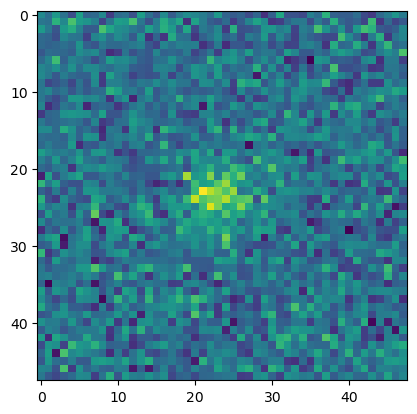

In [36]:
plt.imshow(img)

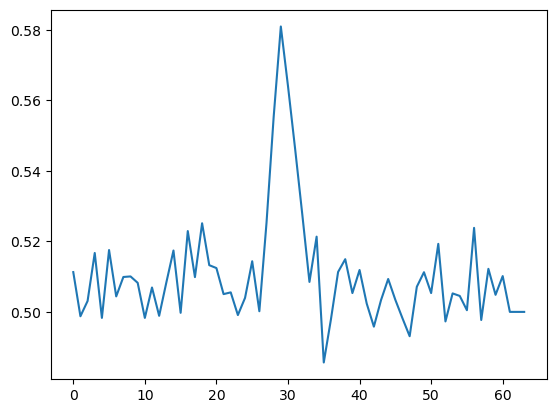

In [37]:
plt.plot(spec[0])